In [6]:
# Previous directory
# C:\Users\snuga\OneDrive\Documents\USF\Research\MIMIC_IV\

In [7]:
# ==============================================================================
# ||                                                                         ||
# ||                 MIMIC_IV_BERT_Pytorch-Classification                    ||
# ||                                                                         ||
# ==============================================================================
# ||                                                                         ||
# ||                  Author: Jessica Elrefaei                               ||
# ||                  Co-Authors: Kevin Hitt,                                ||
# ||                              Sai Charan Dasari,                         ||
# ||                              Yaswanth Chandolu                          ||
# ||                  Date:   2023-10-29                                     ||
# ||                                                                         ||
# ==============================================================================
#
#  This notebook contains an implementation of a classification model using the
#  BERT (Bidirectional Encoder Representations from Transformers) architecture
#  and PyTorch framework.
#  Using the MIMIC-IV (Medical Information Mart for Intensive Care IV) dataset

In [8]:
# -----------------------------------------------------------------------------------------
#                                         Requirements
# -----------------------------------------------------------------------------------------
# - Python 3.x
# - PyTorch
# - Transformers Library
# - Pandas
# - NumPy


In [9]:
pip install transformers datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.0 MB/s eta 0:00:00


In [10]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import pandas as pd
import gzip

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Part 1: Data Preprocessing

In [12]:
with gzip.open(r"admissions.csv.gz", 'rb') as file:
    admissionsdf = pd.read_csv(file)

admissionsdf

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431226,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0
431227,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE,2147-07-17 17:18:00,2147-07-18 17:34:00,0
431228,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P58A9J,EMERGENCY ROOM,DIED,Other,ENGLISH,WIDOWED,WHITE,2164-09-10 11:09:00,2164-09-10 14:46:00,1
431229,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaN,EW EMER.,P506DE,EMERGENCY ROOM,HOME,Other,ENGLISH,WIDOWED,WHITE,2164-07-24 21:16:00,2164-07-25 01:20:00,0


In [13]:
with gzip.open(r"diagnoses_icd.csv.gz", 'rb') as file:
    diagnosesdf = pd.read_csv(file)

diagnosesdf

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
4756321,19999987,23865745,7,41401,9
4756322,19999987,23865745,8,78039,9
4756323,19999987,23865745,9,0413,9
4756324,19999987,23865745,10,36846,9


In [14]:
diagnosesdf.tail(20)

,subject_id,hadm_id,seq_num,icd_code,icd_version
4756306,19999840,21033226,11,9331,9
4756307,19999840,21033226,12,E912,9
4756308,19999840,26071774,1,43491,9
4756309,19999840,26071774,2,43820,9
4756310,19999840,26071774,3,34590,9
4756311,19999840,26071774,4,43811,9
4756312,19999840,26071774,5,4019,9
4756313,19999840,26071774,6,2724,9
4756314,19999840,26071774,7,3051,9
4756315,19999987,23865745,1,431,9


In [15]:
with gzip.open(r"d_icd_diagnoses.csv.gz", 'rb') as file:
    diagnosisdescriptionsdf = pd.read_csv(file)

diagnosisdescriptionsdf

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
...,...,...,...
109770,Z992,10,Dependence on renal dialysis
109771,Z993,10,Dependence on wheelchair
109772,Z998,10,Dependence on other enabling machines and devices
109773,Z9981,10,Dependence on supplemental oxygen


#### INNER merge
rows with matching subject_id & hadm_id in both admissionsdf and diagnosesdf

In [16]:
joineddataset=pd.merge(admissionsdf, diagnosesdf, on=['subject_id', 'hadm_id'])
joineddataset

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,1,5723,9
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2,78959,9
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,3,5715,9
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,4,07070,9
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,5,496,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756321,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,7,41401,9
4756322,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,8,78039,9
4756323,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,9,0413,9
4756324,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,10,36846,9


In [17]:
with gzip.open(r"patients.csv.gz", 'rb') as file:
    patientsdf = pd.read_csv(file)

patientsdf

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


#### LEFT OUTER merge
Columns from patientsdf that are not in joineddataset are added.
Rows from patientsdf that do not have a matching subject_id in joineddataset are not included.

In [18]:
joineddataset2 = pd.merge(joineddataset,patientsdf[['subject_id','anchor_age', 'gender']], on='subject_id', how='left')
joineddataset2

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,anchor_age,gender
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,1,5723,9,52,F
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2,78959,9,52,F
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,3,5715,9,52,F
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,4,07070,9,52,F
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,5,496,9,52,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756321,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,7,41401,9,57,F
4756322,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,8,78039,9,57,F
4756323,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,9,0413,9,57,F
4756324,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,10,36846,9,57,F


In [19]:
joinedandsorteddf=joineddataset2.sort_values(by=['subject_id', 'admittime', 'seq_num'], ascending=True)
joinedandsorteddf

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,anchor_age,gender
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,1,5723,9,52,F
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,2,78959,9,52,F
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,3,5715,9,52,F
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,4,07070,9,52,F
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,5,496,9,52,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756321,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,7,41401,9,57,F
4756322,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,8,78039,9,57,F
4756323,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,9,0413,9,57,F
4756324,19999987,23865745,2145-11-02 21:38:00,2145-11-11 12:57:00,NaN,EW EMER.,P09IS0,EMERGENCY ROOM,REHAB,Other,...,NaN,UNKNOWN,2145-11-02 19:28:00,2145-11-02 22:59:00,0,10,36846,9,57,F


<Axes: >

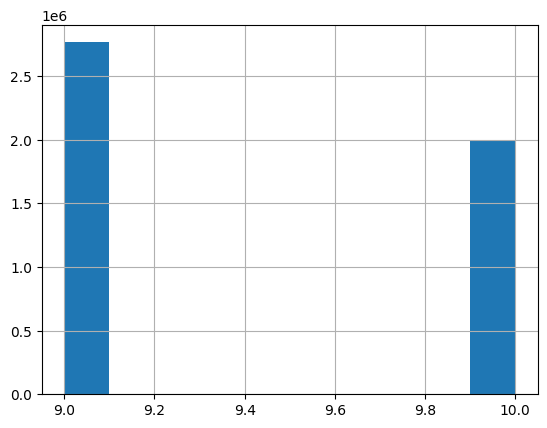

In [20]:
joinedandsorteddf['icd_version'].hist()

#### Filter Based on ICD-10 Code (version 10)

In [21]:
joinedandsorteddf=joinedandsorteddf[joinedandsorteddf["icd_version"]==10]
joinedandsorteddf

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,anchor_age,gender
40,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,1,G3183,10,72,M
41,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,2,F0280,10,72,M
42,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,3,R441,10,72,M
43,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,4,R296,10,72,M
44,10000084,23052089,2160-11-21 01:56:00,2160-11-25 14:52:00,NaN,EW EMER.,P6957U,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,2160-11-20 20:36:00,2160-11-21 03:20:00,0,5,E785,10,72,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756269,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,15,F419,10,46,F
4756270,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,16,E876,10,46,F
4756271,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,17,B954,10,46,F
4756272,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,18,E60,10,46,F


In [22]:
averageage=joinedandsorteddf.groupby('race', as_index=False)['anchor_age'].mean().sort_values(by=['anchor_age'])
averageage

,race,anchor_age
17,HISPANIC/LATINO - MEXICAN,48.819292
29,WHITE - BRAZILIAN,50.088816
4,ASIAN - KOREAN,52.022636
14,HISPANIC/LATINO - DOMINICAN,52.263907
19,HISPANIC/LATINO - SALVADORAN,52.396809
15,HISPANIC/LATINO - GUATEMALAN,52.927043
18,HISPANIC/LATINO - PUERTO RICAN,53.913656
16,HISPANIC/LATINO - HONDURAN,54.049141
6,BLACK/AFRICAN,54.925305
7,BLACK/AFRICAN AMERICAN,55.895933


#### Number of unique ICD-10 Codes

In [23]:
icdcount=joinedandsorteddf.icd_code.nunique()
icdcount

16757

#### Most Frequent ICD-10 Codes

In [24]:
icdgroupcount=joinedandsorteddf.groupby(['icd_code'])['subject_id'].nunique().sort_values(ascending=False)
icdgroupcount=pd.DataFrame(icdgroupcount)
icdgroupcount = icdgroupcount.merge(diagnosisdescriptionsdf, on='icd_code', how='left')

In [25]:
icdgroupcount

,icd_code,subject_id,icd_version,long_title
0,I10,31521,10,Essential (primary) hypertension
1,E785,27903,10,"Hyperlipidemia, unspecified"
2,Z87891,21356,10,Personal history of nicotine dependence
3,K219,19067,10,Gastro-esophageal reflux disease without esoph...
4,F329,16476,10,"Major depressive disorder, single episode, uns..."
...,...,...,...,...
16787,S67195S,1,10,"Crushing injury of left ring finger, sequela"
16788,I82719,1,10,Chronic embolism and thrombosis of superficial...
16789,I82712,1,10,Chronic embolism and thrombosis of superficial...
16790,N9411,1,10,Superficial (introital) dyspareunia


#### Total Number of Patients

In [26]:
patientcount=joinedandsorteddf.subject_id.nunique()
patientcount

80213

#### Deceased Patient Count

In [27]:
deceasedpatientcounts=joinedandsorteddf[joinedandsorteddf["deathtime"].notnull()]["subject_id"].nunique()
deceasedpatientcounts

3360

#### Dataframe just based on Deceased Patients

In [28]:
deceasedpatients=joinedandsorteddf[joinedandsorteddf["deathtime"].notnull()]
deceasedpatients

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,anchor_age,gender
750,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,1,J441,10,68,F
751,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,2,K7200,10,68,F
752,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,3,R579,10,68,F
753,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,4,J9602,10,68,F
754,10001884,26184834,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,OBSERVATION ADMIT,P874LG,EMERGENCY ROOM,DIED,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2131-01-07 13:36:00,2131-01-07 22:13:00,1,5,J9601,10,68,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751631,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,24,T24011A,10,67,F
4751632,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,25,Y658,10,67,F
4751633,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,26,Y92230,10,67,F
4751634,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,27,H168,10,67,F


#### List of Deceased Patients

In [29]:
arrayofdeceasedpatients=deceasedpatients["subject_id"].unique().copy()
listofdeceasedpatients=arrayofdeceasedpatients.tolist()
listofdeceasedpatients

[10001884,
 10003400,
 10004720,
 10005817,
 10007818,
 10010058,
 10010471,
 10011365,
 10015931,
 10021927,
 10023117,
 10024982,
 10026879,
 10032409,
 10035631,
 10037861,
 10038688,
 10046679,
 10047172,
 10050445,
 10050755,
 10055344,
 10055694,
 10059406,
 10064049,
 10067389,
 10069692,
 10071869,
 10073239,
 10076958,
 10078805,
 10079545,
 10080695,
 10082662,
 10097659,
 10106165,
 10113636,
 10115044,
 10118141,
 10119017,
 10119992,
 10131638,
 10132611,
 10133363,
 10133599,
 10134367,
 10135376,
 10142197,
 10144378,
 10152346,
 10155871,
 10157542,
 10162760,
 10168722,
 10177348,
 10179383,
 10179842,
 10183369,
 10184327,
 10187075,
 10192651,
 10197095,
 10201643,
 10206125,
 10207354,
 10213338,
 10236222,
 10236280,
 10236942,
 10237748,
 10239650,
 10240102,
 10246238,
 10249699,
 10250007,
 10252642,
 10257550,
 10260379,
 10261293,
 10263326,
 10269234,
 10272082,
 10272169,
 10274368,
 10284297,
 10289851,
 10291949,
 10292730,
 10295734,
 10300273,
 10302157,

In [30]:
#See if it Checks out

len(listofdeceasedpatients)

#yes

3360

#### Filter original dataframe based on the deceased patients list

In [31]:
joinedandsorteddf2=joinedandsorteddf[joinedandsorteddf['subject_id'].isin(listofdeceasedpatients)]
joinedandsorteddf2

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,anchor_age,gender
819,10001884,27016754,2130-06-23 22:14:00,2130-06-24 11:07:00,NaN,EU OBSERVATION,P21E4S,EMERGENCY ROOM,NaN,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-06-23 17:42:00,2130-06-24 11:07:00,0,1,J441,10,68,F
821,10001884,27016754,2130-06-23 22:14:00,2130-06-24 11:07:00,NaN,EU OBSERVATION,P21E4S,EMERGENCY ROOM,NaN,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-06-23 17:42:00,2130-06-24 11:07:00,0,2,F17210,10,68,F
823,10001884,27016754,2130-06-23 22:14:00,2130-06-24 11:07:00,NaN,EU OBSERVATION,P21E4S,EMERGENCY ROOM,NaN,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-06-23 17:42:00,2130-06-24 11:07:00,0,3,R079,10,68,F
786,10001884,26202981,2130-08-21 15:26:00,2130-08-23 16:40:00,NaN,EW EMER.,P20301,EMERGENCY ROOM,HOME,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-08-21 12:14:00,2130-08-21 16:51:00,0,1,K921,10,68,F
787,10001884,26202981,2130-08-21 15:26:00,2130-08-23 16:40:00,NaN,EW EMER.,P20301,EMERGENCY ROOM,HOME,Medicare,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-08-21 12:14:00,2130-08-21 16:51:00,0,2,D62,10,68,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751631,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,24,T24011A,10,67,F
4751632,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,25,Y658,10,67,F
4751633,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,26,Y92230,10,67,F
4751634,19990427,29695607,2182-01-04 00:00:00,2182-01-24 00:00:00,2182-01-24 23:15:00,SURGICAL SAME DAY ADMISSION,P39FGY,PHYSICIAN REFERRAL,DIED,Medicare,...,MARRIED,WHITE,NaN,NaN,1,27,H168,10,67,F


#### Group the DataFrame by 'subject_id' and 'admittime' & get list of ICD codes as a list for each group 🔥

In [32]:
#groupedlist=joinedandsorteddf2.groupby(["subject_id", "admittime"], as_index=False)["icd_code"].apply(list)
# below (uses 'agg' function instead of `.apply(list)` to avoid error on KH's machine)

groupedlist = joinedandsorteddf2.groupby(["subject_id", "admittime"]).agg({'icd_code': list}).reset_index()
groupedlist

,subject_id,admittime,icd_code
0,10001884,2130-06-23 22:14:00,"[J441, F17210, R079]"
1,10001884,2130-08-21 15:26:00,"[K921, D62, I4891, J449, I10, F17210, D649, I2..."
2,10001884,2130-10-05 20:04:00,"[J441, R0902, E876, I10, E780, E785, Z87891, Z..."
3,10001884,2130-10-08 19:03:00,"[I4891, J441, Z9981, Z7901, I10, E785, F419, I..."
4,10001884,2130-10-14 00:58:00,"[J441, Z9981, I10, I4891, Z7901, Z87891]"
...,...,...,...
8549,19984052,2184-11-22 17:00:00,"[I82412, N179, I498, Z951, I469, I82442, I10, ..."
8550,19984875,2118-01-05 00:18:00,"[C7931, G936, G9340, Z85118, F419, D509, Z902,..."
8551,19984875,2118-02-04 19:36:00,"[C7931, G936, G9349, G8191, G40109, R64, Z6826..."
8552,19984875,2118-04-18 21:31:00,"[C7931, G936, J9691, R4701, Z515, C3491, G8191..."


In [33]:
#drop admittime
groupedlist = groupedlist.drop(columns=['admittime']).copy()
groupedlist

,subject_id,icd_code
0,10001884,"[J441, F17210, R079]"
1,10001884,"[K921, D62, I4891, J449, I10, F17210, D649, I2..."
2,10001884,"[J441, R0902, E876, I10, E780, E785, Z87891, Z..."
3,10001884,"[I4891, J441, Z9981, Z7901, I10, E785, F419, I..."
4,10001884,"[J441, Z9981, I10, I4891, Z7901, Z87891]"
...,...,...
8549,19984052,"[I82412, N179, I498, Z951, I469, I82442, I10, ..."
8550,19984875,"[C7931, G936, G9340, Z85118, F419, D509, Z902,..."
8551,19984875,"[C7931, G936, G9349, G8191, G40109, R64, Z6826..."
8552,19984875,"[C7931, G936, J9691, R4701, Z515, C3491, G8191..."


In [34]:
#Convert to string

groupedlist['icd_code'] = groupedlist['icd_code'].astype(str)
groupedlist

,subject_id,icd_code
0,10001884,"['J441', 'F17210', 'R079']"
1,10001884,"['K921', 'D62', 'I4891', 'J449', 'I10', 'F1721..."
2,10001884,"['J441', 'R0902', 'E876', 'I10', 'E780', 'E785..."
3,10001884,"['I4891', 'J441', 'Z9981', 'Z7901', 'I10', 'E7..."
4,10001884,"['J441', 'Z9981', 'I10', 'I4891', 'Z7901', 'Z8..."
...,...,...
8549,19984052,"['I82412', 'N179', 'I498', 'Z951', 'I469', 'I8..."
8550,19984875,"['C7931', 'G936', 'G9340', 'Z85118', 'F419', '..."
8551,19984875,"['C7931', 'G936', 'G9349', 'G8191', 'G40109', ..."
8552,19984875,"['C7931', 'G936', 'J9691', 'R4701', 'Z515', 'C..."


#### Filter for only partients with CARDIAC ARREST IN FINAL SEQUENCE (cause of death)

In [35]:
newgroupedlist=groupedlist.drop_duplicates('subject_id',keep='last').\
           assign(Flag=lambda x : x['icd_code'].str.contains('I462|I468|I469').astype(int))



newgroupedlist=newgroupedlist[newgroupedlist['Flag']==1]


arrayofdeceasedcardiacarrestpatients=newgroupedlist["subject_id"].unique().copy()
listofdeceasedcardiacarrestpatients=arrayofdeceasedcardiacarrestpatients.tolist()
print(len(listofdeceasedcardiacarrestpatients))

363


#### targetpatients = all sequences for patients where cardiac arrest was cause of death

In [36]:
targetpatients=groupedlist[groupedlist['subject_id'].isin(listofdeceasedcardiacarrestpatients)]
targetpatients

,subject_id,icd_code
0,10001884,"['J441', 'F17210', 'R079']"
1,10001884,"['K921', 'D62', 'I4891', 'J449', 'I10', 'F1721..."
2,10001884,"['J441', 'R0902', 'E876', 'I10', 'E780', 'E785..."
3,10001884,"['I4891', 'J441', 'Z9981', 'Z7901', 'I10', 'E7..."
4,10001884,"['J441', 'Z9981', 'I10', 'I4891', 'Z7901', 'Z8..."
...,...,...
8526,19942414,"['I748', 'I5033', 'A419', 'R6521', 'N280', 'N1..."
8528,19948220,"['I469', 'R4020', 'J9601', 'J930', 'E872', 'I4..."
8548,19984052,"['I2510', 'D696', 'E119', 'E669', 'Z794', 'I10..."
8549,19984052,"['I82412', 'N179', 'I498', 'Z951', 'I469', 'I8..."


#### Aggregate to one row for each subject_id

In [37]:
newtargetpatients = (targetpatients.groupby(['subject_id'])
       .agg({'icd_code': lambda x: ', '.join(x)})
       .reset_index()
)

newtargetpatients

,subject_id,icd_code
0,10001884,"['J441', 'F17210', 'R079'], ['K921', 'D62', 'I..."
1,10010471,"['I4891', 'N186', 'J189', 'Z7682', 'I248', 'J4..."
2,10024982,"['I25110', 'Z951', 'I4891', 'J449', 'Z87891', ..."
3,10050755,"['I63132', 'J189', 'J690', 'E43', 'N179', 'G92..."
4,10067389,"['J690', 'L89153', 'I639', 'N170', 'J9601', 'K..."
...,...,...
358,19940062,"['G935', 'G950', 'I252', 'N400', 'V499XXS', 'Z..."
359,19942414,"['I748', 'I5033', 'A419', 'R6521', 'N280', 'N1..."
360,19948220,"['I469', 'R4020', 'J9601', 'J930', 'E872', 'I4..."
361,19984052,"['I2510', 'D696', 'E119', 'E669', 'Z794', 'I10..."


In [38]:
newtargetpatients=newtargetpatients['icd_code'].values.tolist()
newtargetpatients

["['J441', 'F17210', 'R079'], ['K921', 'D62', 'I4891', 'J449', 'I10', 'F17210', 'D649', 'I2510', 'F419', 'E785', 'I739', 'M47892', 'R0602', 'G4700', 'H409', 'K449', 'K2970', 'Z7982', 'Z7901', 'Z96649'], ['J441', 'R0902', 'E876', 'I10', 'E780', 'E785', 'Z87891', 'Z9981'], ['I4891', 'J441', 'Z9981', 'Z7901', 'I10', 'E785', 'F419', 'I739', 'I2510', 'Z87891', 'D509', 'R079', 'G4700', 'H409'], ['J441', 'Z9981', 'I10', 'I4891', 'Z7901', 'Z87891'], ['J441', 'I4892', 'Z9981', 'I480', 'J45998', 'Z87891', 'I2510', 'Z96649', 'I10', 'E785', 'D509', 'I739', 'F419', 'K5900', 'M1990', 'Z825', 'Z8249', 'Z7901'], ['J441', 'M7989', 'I2510', 'I499', 'I739', 'F419', 'Z87891', 'E876'], ['J441', 'I4892', 'I248', 'J45909', 'Z87891', 'I4891', 'F419', 'G4700', 'E780', 'I2510', 'E876', 'R312', 'I739', 'Z7952', 'Z9981'], ['J441', 'Z9981', 'I4891', 'J45909', 'Z7901', 'I10', 'I2510', 'E785', 'M1990', 'F419', 'I739', 'G4700', 'D649', 'Z96649', 'Z87891'], ['J441', 'J45909', 'H6991', 'F419', 'G4700', 'I4891', 'Z7901'

In [39]:
from ast import literal_eval

example=newtargetpatients

result2=[]
for st in example:

    # Use 'literal_eval' to convert the string representation of a list to an actual list
    # The unpacking operation separates the list into two parts: 'first_grp' containing
    # all but the last element, and 'last' containing the last element
    *first_grp,last=literal_eval(st)

    # if 'first_grp' or 'last' contain a string element, skip
    if any(isinstance(s, str) for s in (first_grp, last)):
        continue

    # Flatten 'first_grp' and join its elements into a single string, separated by spaces
    # Join the elements in 'last' into another string, separated by spaces
    result=[" ".join([e for r in first_grp for e in r]), " ".join(last)]
    result2.append(result)

print(result2)

[['J441 F17210 R079 K921 D62 I4891 J449 I10 F17210 D649 I2510 F419 E785 I739 M47892 R0602 G4700 H409 K449 K2970 Z7982 Z7901 Z96649 J441 R0902 E876 I10 E780 E785 Z87891 Z9981 I4891 J441 Z9981 Z7901 I10 E785 F419 I739 I2510 Z87891 D509 R079 G4700 H409 J441 Z9981 I10 I4891 Z7901 Z87891 J441 I4892 Z9981 I480 J45998 Z87891 I2510 Z96649 I10 E785 D509 I739 F419 K5900 M1990 Z825 Z8249 Z7901 J441 M7989 I2510 I499 I739 F419 Z87891 E876 J441 I4892 I248 J45909 Z87891 I4891 F419 G4700 E780 I2510 E876 R312 I739 Z7952 Z9981 J441 Z9981 I4891 J45909 Z7901 I10 I2510 E785 M1990 F419 I739 G4700 D649 Z96649 Z87891 J441 J45909 H6991 F419 G4700 I4891 Z7901 I10 I2510 D649 E785 Z87891 Z006 J441 N179 Z9981 I4891 D649 I10 E785 G5622 I2510 M1990 Z96649 Z87891 J45909 F419 G4700 R040 I739', 'J441 K7200 R579 J9602 J9601 I442 I82621 I4891 D696 I469 I10 E785 Z7901 M47892 I7389 I2510 Z87891 Z96641 J0190 F419 G4700 R609 D509 R509 M1990 Y92239 Z7952 Z825 Z781 Z515 Z66 Z9981 J45909 I447 M7981 T45515A'], ['I4891 N186 J189 

# Part 2: Model Architecture

In [40]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [41]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        #read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = result2

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [42]:
MAX_LEN = 250

def filterPair(p):
    return len(p[0]) < MAX_LEN and \
        len(p[1]) < MAX_LEN


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [43]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', False)
print(random.choice(pairs))

Reading lines...
Read 140 sentence pairs
Trimmed to 87 sentence pairs
Counting words...
Counted words:
eng 716
fra 733
['G9389 G911 E6601 Z86711 Z86718 Z87891 E780 Z853 Z6836 C710 G936 G911 Z853 Z9011 E6601 Z86711 Z86718 Z87891 R5082 K219 E780 Z6834 Z806', 'R569 G92 G936 I2119 I2699 C715 C50911 Z66 Z982 S0511XA W06XXXA Y92003 R270 R32 R112 F329 F419 E042 Z86718 Z86711 G8929 M549 K219 G250 R159 E7800 I469 Z87891']


## WordPiece tokenizer

In [44]:
### save data as txt file
os.mkdir(r'./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train(
    files=paths,
    vocab_size=30_000,
    min_frequency=5,
    limit_alphabet=1000,
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 87/87 [00:00<00:00, 761804.69it/s]
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


## BERTDataset

In [45]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=250):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

In [46]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)
sample_data = next(iter(train_loader))
print(train_data[random.randrange(len(train_data))])

{'bert_input': tensor([1, 4, 4, 4, 1, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'bert_label': tensor([0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0

## PositionalEmbedding

In [47]:
class PositionalEmbedding(torch.nn.Module):

    def __init__(self, d_model, max_len=128):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):
            # for each dimension of the each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe

## BERTEmbedding

In [48]:
class BERTEmbedding(torch.nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, seq_len=250, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """

        super().__init__()
        self.embed_size = embed_size
        # (m, seq_len) --> (m, seq_len, embed_size)
        # padding_idx is not updated during training, remains as fixed pad (0)
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

## MultiHeadedAttention

In [49]:
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)


## FeedForward

In [50]:
class FeedForward(torch.nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out


## Encoder Layer

In [51]:
class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## BERT

In [52]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # paper noted they used 4 * hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = d_model * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

        # multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

## NextSentencePrediction

In [53]:
class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

## MaskedLanguageModel

In [54]:
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

## BERTLM

In [55]:
class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

## ScheduledOptim

In [56]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## BERTTrainer

In [57]:
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda',
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader
        self.train_loss_list = []           # KH
        self.test_loss_list = []            # KH
        self.train_acc_list = []            # KH
        self.test_acc_list = []             # KH

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )

        # KH
        total_acc = total_correct * 100.0 / total_element
        avg_epoch_loss = avg_loss / len(data_loader)
        from sklearn.metrics import precision_recall_fscore_support as score
        precision, recall, fscore, _ = score(data["is_next"].cpu().numpy(),
                                     next_sent_output.argmax(dim=-1).cpu().numpy(),
                                     average='binary')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {fscore:.4f}')
        if train:
            self.train_loss_list.append(avg_epoch_loss)
            self.train_acc_list.append(total_acc)  # Append training accuracy
        else:
            self.test_loss_list.append(avg_epoch_loss)
            self.test_acc_list.append(total_acc)  # Append testing accuracy

        if mode == 'test':
            # assuming mask_loss is the loss for MLM
            perplexity = torch.exp(mask_loss).item()
            print(f"EP{epoch}, {mode}: perplexity={perplexity}")

# Part 3: Model Training and Testing

#### (Training trial run)

In [58]:
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 5

for epoch in range(epochs):
  bert_trainer.train(epoch)

Total Parameters: 14184199


EP_train:0:  33%|| 1/3 [00:10<00:20, 10.13s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 2.149665117263794, 'avg_acc': 50.0, 'loss': 2.149665117263794}


EP_train:0: 100%|| 3/3 [00:25<00:00,  8.62s/it]


EP0, train:             avg_loss=2.1431864897410073,             total_acc=49.42528735632184
Precision: 0.2500
Recall: 0.1111
F1-Score: 0.1538


EP_train:1:  33%|| 1/3 [00:08<00:17,  8.64s/it]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.05167818069458, 'avg_acc': 46.875, 'loss': 2.05167818069458}


EP_train:1: 100%|| 3/3 [00:23<00:00,  7.99s/it]


EP1, train:             avg_loss=2.046248515446981,             total_acc=51.724137931034484
Precision: 0.6250
Recall: 0.5000
F1-Score: 0.5556


EP_train:2:  33%|| 1/3 [00:09<00:18,  9.48s/it]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.0515425205230713, 'avg_acc': 46.875, 'loss': 2.0515425205230713}


EP_train:2: 100%|| 3/3 [00:24<00:00,  8.12s/it]


EP2, train:             avg_loss=2.050245761871338,             total_acc=40.229885057471265
Precision: 0.4667
Recall: 0.5385
F1-Score: 0.5000


EP_train:3:  33%|| 1/3 [00:08<00:17,  8.53s/it]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.0402753353118896, 'avg_acc': 53.125, 'loss': 2.0402753353118896}


EP_train:3: 100%|| 3/3 [00:25<00:00,  8.57s/it]


EP3, train:             avg_loss=2.0146776040395102,             total_acc=50.57471264367816
Precision: 0.5000
Recall: 0.4615
F1-Score: 0.4800


EP_train:4:  33%|| 1/3 [00:07<00:15,  7.98s/it]

{'epoch': 4, 'iter': 0, 'avg_loss': 1.8975520133972168, 'avg_acc': 59.375, 'loss': 1.8975520133972168}


EP_train:4: 100%|| 3/3 [00:22<00:00,  7.56s/it]

EP4, train:             avg_loss=1.9218660593032837,             total_acc=49.42528735632184
Precision: 0.4667
Recall: 0.5833
F1-Score: 0.5185


## Testing

### Split Dataset into Training and Testing Sets

In [59]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

### Initialize Data Loaders for Training and Testing Sets

In [60]:
# Training set
train_data = BERTDataset(train_pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)

# Test set
test_data = BERTDataset(test_pairs, seq_len=MAX_LEN, tokenizer=tokenizer)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)

### Initialize BERTTrainer with Training and Test Data

In [61]:
bert_trainer = BERTTrainer(bert_lm, train_loader, test_dataloader=test_loader, device='cpu')

Total Parameters: 14184199


In [62]:
epochs = 20

for epoch in range(epochs):
    bert_trainer.train(epoch)  # Training
    bert_trainer.test(epoch)  # Testing

EP_train:0:  33%|| 1/3 [00:09<00:18,  9.46s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 1.8296449184417725, 'avg_acc': 56.25, 'loss': 1.8296449184417725}


EP_train:0: 100%|| 3/3 [00:18<00:00,  6.29s/it]


EP0, train:             avg_loss=1.8739162683486938,             total_acc=53.6231884057971
Precision: 0.7500
Recall: 1.0000
F1-Score: 0.8571


EP_test:0: 100%|| 1/1 [00:02<00:00,  2.34s/it]


{'epoch': 0, 'iter': 0, 'avg_loss': 1.8123116493225098, 'avg_acc': 72.22222222222221, 'loss': 1.8123116493225098}
EP0, test:             avg_loss=1.8123116493225098,             total_acc=72.22222222222223
Precision: 0.6000
Recall: 0.8571
F1-Score: 0.7059
EP0, test: perplexity=3.5975852012634277


EP_train:1:  33%|| 1/3 [00:08<00:16,  8.49s/it]

{'epoch': 1, 'iter': 0, 'avg_loss': 1.9017395973205566, 'avg_acc': 46.875, 'loss': 1.9017395973205566}


EP_train:1: 100%|| 3/3 [00:19<00:00,  6.47s/it]


EP1, train:             avg_loss=1.91853133837382,             total_acc=44.927536231884055
Precision: 0.5000
Recall: 0.6667
F1-Score: 0.5714


EP_test:1: 100%|| 1/1 [00:01<00:00,  1.57s/it]


{'epoch': 1, 'iter': 0, 'avg_loss': 1.9329581260681152, 'avg_acc': 66.66666666666666, 'loss': 1.9329581260681152}
EP1, test:             avg_loss=1.9329581260681152,             total_acc=66.66666666666667
Precision: 0.6364
Recall: 0.7778
F1-Score: 0.7000
EP1, test: perplexity=3.672111988067627


EP_train:2:  33%|| 1/3 [00:08<00:17,  8.89s/it]

{'epoch': 2, 'iter': 0, 'avg_loss': 1.8786911964416504, 'avg_acc': 46.875, 'loss': 1.8786911964416504}


EP_train:2: 100%|| 3/3 [00:18<00:00,  6.26s/it]


EP2, train:             avg_loss=1.8192699352900188,             total_acc=47.82608695652174
Precision: 0.3333
Recall: 0.5000
F1-Score: 0.4000


EP_test:2: 100%|| 1/1 [00:01<00:00,  1.57s/it]


{'epoch': 2, 'iter': 0, 'avg_loss': 1.7986268997192383, 'avg_acc': 72.22222222222221, 'loss': 1.7986268997192383}
EP2, test:             avg_loss=1.7986268997192383,             total_acc=72.22222222222223
Precision: 0.7143
Recall: 0.9091
F1-Score: 0.8000
EP2, test: perplexity=3.340052843093872


EP_train:3:  33%|| 1/3 [00:09<00:18,  9.18s/it]

{'epoch': 3, 'iter': 0, 'avg_loss': 1.8361096382141113, 'avg_acc': 40.625, 'loss': 1.8361096382141113}


EP_train:3: 100%|| 3/3 [00:19<00:00,  6.60s/it]


EP3, train:             avg_loss=1.8763997554779053,             total_acc=39.130434782608695
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667


EP_test:3: 100%|| 1/1 [00:01<00:00,  1.85s/it]


{'epoch': 3, 'iter': 0, 'avg_loss': 1.7738752365112305, 'avg_acc': 44.44444444444444, 'loss': 1.7738752365112305}
EP3, test:             avg_loss=1.7738752365112305,             total_acc=44.44444444444444
Precision: 0.4000
Recall: 0.8571
F1-Score: 0.5455
EP3, test: perplexity=3.2520906925201416


EP_train:4:  33%|| 1/3 [00:07<00:15,  7.74s/it]

{'epoch': 4, 'iter': 0, 'avg_loss': 1.8927385807037354, 'avg_acc': 34.375, 'loss': 1.8927385807037354}


EP_train:4: 100%|| 3/3 [00:18<00:00,  6.22s/it]


EP4, train:             avg_loss=1.867598334948222,             total_acc=40.57971014492754
Precision: 0.2500
Recall: 1.0000
F1-Score: 0.4000


EP_test:4: 100%|| 1/1 [00:01<00:00,  1.61s/it]


{'epoch': 4, 'iter': 0, 'avg_loss': 1.7481863498687744, 'avg_acc': 38.88888888888889, 'loss': 1.7481863498687744}
EP4, test:             avg_loss=1.7481863498687744,             total_acc=38.888888888888886
Precision: 0.3529
Recall: 1.0000
F1-Score: 0.5217
EP4, test: perplexity=3.3352200984954834


EP_train:5:  33%|| 1/3 [00:09<00:19,  9.53s/it]

{'epoch': 5, 'iter': 0, 'avg_loss': 1.7884759902954102, 'avg_acc': 46.875, 'loss': 1.7884759902954102}


EP_train:5: 100%|| 3/3 [00:19<00:00,  6.35s/it]


EP5, train:             avg_loss=1.721778114636739,             total_acc=43.47826086956522
Precision: 0.5000
Recall: 0.6667
F1-Score: 0.5714


EP_test:5: 100%|| 1/1 [00:02<00:00,  2.25s/it]


{'epoch': 5, 'iter': 0, 'avg_loss': 1.615979790687561, 'avg_acc': 66.66666666666666, 'loss': 1.615979790687561}
EP5, test:             avg_loss=1.615979790687561,             total_acc=66.66666666666667
Precision: 0.7059
Recall: 0.9231
F1-Score: 0.8000
EP5, test: perplexity=3.021759033203125


EP_train:6:  33%|| 1/3 [00:08<00:16,  8.28s/it]

{'epoch': 6, 'iter': 0, 'avg_loss': 1.5942161083221436, 'avg_acc': 56.25, 'loss': 1.5942161083221436}


EP_train:6: 100%|| 3/3 [00:19<00:00,  6.58s/it]


EP6, train:             avg_loss=1.6365193923314412,             total_acc=57.971014492753625
Precision: 0.8000
Recall: 1.0000
F1-Score: 0.8889


EP_test:6: 100%|| 1/1 [00:01<00:00,  1.65s/it]


{'epoch': 6, 'iter': 0, 'avg_loss': 1.5002802610397339, 'avg_acc': 44.44444444444444, 'loss': 1.5002802610397339}
EP6, test:             avg_loss=1.5002802610397339,             total_acc=44.44444444444444
Precision: 0.4444
Recall: 1.0000
F1-Score: 0.6154
EP6, test: perplexity=2.893440008163452


EP_train:7:  33%|| 1/3 [00:09<00:18,  9.22s/it]

{'epoch': 7, 'iter': 0, 'avg_loss': 1.5887792110443115, 'avg_acc': 53.125, 'loss': 1.5887792110443115}


EP_train:7: 100%|| 3/3 [00:19<00:00,  6.38s/it]


EP7, train:             avg_loss=1.536311666170756,             total_acc=52.17391304347826
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:7: 100%|| 1/1 [00:01<00:00,  1.82s/it]


{'epoch': 7, 'iter': 0, 'avg_loss': 1.4774082899093628, 'avg_acc': 55.55555555555556, 'loss': 1.4774082899093628}
EP7, test:             avg_loss=1.4774082899093628,             total_acc=55.55555555555556
Precision: 0.5556
Recall: 1.0000
F1-Score: 0.7143
EP7, test: perplexity=2.9185471534729004


EP_train:8:  33%|| 1/3 [00:08<00:17,  9.00s/it]

{'epoch': 8, 'iter': 0, 'avg_loss': 1.433586597442627, 'avg_acc': 37.5, 'loss': 1.433586597442627}


EP_train:8: 100%|| 3/3 [00:19<00:00,  6.63s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EP8, train:             avg_loss=nan,             total_acc=33.333333333333336
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


EP_test:8: 100%|| 1/1 [00:01<00:00,  1.57s/it]


{'epoch': 8, 'iter': 0, 'avg_loss': 1.4051997661590576, 'avg_acc': 61.111111111111114, 'loss': 1.4051997661590576}
EP8, test:             avg_loss=1.4051997661590576,             total_acc=61.111111111111114
Precision: 0.6111
Recall: 1.0000
F1-Score: 0.7586
EP8, test: perplexity=2.647995710372925


EP_train:9:  33%|| 1/3 [00:08<00:16,  8.26s/it]

{'epoch': 9, 'iter': 0, 'avg_loss': 1.4073745012283325, 'avg_acc': 40.625, 'loss': 1.4073745012283325}


EP_train:9: 100%|| 3/3 [00:18<00:00,  6.27s/it]


EP9, train:             avg_loss=1.3091569344202678,             total_acc=47.82608695652174
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714


EP_test:9: 100%|| 1/1 [00:01<00:00,  1.69s/it]


{'epoch': 9, 'iter': 0, 'avg_loss': 1.2484104633331299, 'avg_acc': 33.33333333333333, 'loss': 1.2484104633331299}
EP9, test:             avg_loss=1.2484104633331299,             total_acc=33.333333333333336
Precision: 0.3333
Recall: 1.0000
F1-Score: 0.5000
EP9, test: perplexity=2.4828615188598633


EP_train:10:  33%|| 1/3 [00:09<00:19,  9.70s/it]

{'epoch': 10, 'iter': 0, 'avg_loss': 1.285125970840454, 'avg_acc': 56.25, 'loss': 1.285125970840454}


EP_train:10: 100%|| 3/3 [00:20<00:00,  6.74s/it]


EP10, train:             avg_loss=1.2497636874516804,             total_acc=63.768115942028984
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


EP_test:10: 100%|| 1/1 [00:02<00:00,  2.11s/it]


{'epoch': 10, 'iter': 0, 'avg_loss': 1.2472999095916748, 'avg_acc': 55.55555555555556, 'loss': 1.2472999095916748}
EP10, test:             avg_loss=1.2472999095916748,             total_acc=55.55555555555556
Precision: 0.5556
Recall: 1.0000
F1-Score: 0.7143
EP10, test: perplexity=2.4161148071289062


EP_train:11:  33%|| 1/3 [00:07<00:15,  7.76s/it]

{'epoch': 11, 'iter': 0, 'avg_loss': 1.2391009330749512, 'avg_acc': 53.125, 'loss': 1.2391009330749512}


EP_train:11: 100%|| 3/3 [00:18<00:00,  6.17s/it]


EP11, train:             avg_loss=1.2033476829528809,             total_acc=56.52173913043478
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:11: 100%|| 1/1 [00:01<00:00,  1.58s/it]


{'epoch': 11, 'iter': 0, 'avg_loss': 1.1896755695343018, 'avg_acc': 33.33333333333333, 'loss': 1.1896755695343018}
EP11, test:             avg_loss=1.1896755695343018,             total_acc=33.333333333333336
Precision: 0.3333
Recall: 1.0000
F1-Score: 0.5000
EP11, test: perplexity=2.2538230419158936


EP_train:12:  33%|| 1/3 [00:09<00:19,  9.51s/it]

{'epoch': 12, 'iter': 0, 'avg_loss': 1.0416371822357178, 'avg_acc': 59.375, 'loss': 1.0416371822357178}


EP_train:12: 100%|| 3/3 [00:18<00:00,  6.18s/it]


EP12, train:             avg_loss=0.991725742816925,             total_acc=49.27536231884058
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714


EP_test:12: 100%|| 1/1 [00:01<00:00,  1.97s/it]


{'epoch': 12, 'iter': 0, 'avg_loss': 1.050737977027893, 'avg_acc': 61.111111111111114, 'loss': 1.050737977027893}
EP12, test:             avg_loss=1.050737977027893,             total_acc=61.111111111111114
Precision: 0.6111
Recall: 1.0000
F1-Score: 0.7586
EP12, test: perplexity=2.2433128356933594


EP_train:13:  33%|| 1/3 [00:08<00:17,  8.62s/it]

{'epoch': 13, 'iter': 0, 'avg_loss': 1.04677152633667, 'avg_acc': 40.625, 'loss': 1.04677152633667}


EP_train:13: 100%|| 3/3 [00:19<00:00,  6.64s/it]


EP13, train:             avg_loss=1.0302196939786274,             total_acc=52.17391304347826
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:13: 100%|| 1/1 [00:01<00:00,  1.57s/it]


{'epoch': 13, 'iter': 0, 'avg_loss': 0.9233711957931519, 'avg_acc': 44.44444444444444, 'loss': 0.9233711957931519}
EP13, test:             avg_loss=0.9233711957931519,             total_acc=44.44444444444444
Precision: 0.4444
Recall: 1.0000
F1-Score: 0.6154
EP13, test: perplexity=1.9765442609786987


EP_train:14:  33%|| 1/3 [00:08<00:16,  8.23s/it]

{'epoch': 14, 'iter': 0, 'avg_loss': 0.957861602306366, 'avg_acc': 50.0, 'loss': 0.957861602306366}


EP_train:14: 100%|| 3/3 [00:18<00:00,  6.19s/it]


EP14, train:             avg_loss=0.8938770095507304,             total_acc=53.6231884057971
Precision: 0.8000
Recall: 1.0000
F1-Score: 0.8889


EP_test:14: 100%|| 1/1 [00:01<00:00,  1.60s/it]


{'epoch': 14, 'iter': 0, 'avg_loss': 0.8432796001434326, 'avg_acc': 66.66666666666666, 'loss': 0.8432796001434326}
EP14, test:             avg_loss=0.8432796001434326,             total_acc=66.66666666666667
Precision: 0.6667
Recall: 1.0000
F1-Score: 0.8000
EP14, test: perplexity=1.9068602323532104


EP_train:15:  33%|| 1/3 [00:09<00:18,  9.34s/it]

{'epoch': 15, 'iter': 0, 'avg_loss': 0.8812446594238281, 'avg_acc': 46.875, 'loss': 0.8812446594238281}


EP_train:15: 100%|| 3/3 [00:19<00:00,  6.51s/it]


EP15, train:             avg_loss=0.8468738396962484,             total_acc=46.3768115942029
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:15: 100%|| 1/1 [00:02<00:00,  2.11s/it]


{'epoch': 15, 'iter': 0, 'avg_loss': 0.7270630598068237, 'avg_acc': 38.88888888888889, 'loss': 0.7270630598068237}
EP15, test:             avg_loss=0.7270630598068237,             total_acc=38.888888888888886
Precision: 0.3889
Recall: 1.0000
F1-Score: 0.5600
EP15, test: perplexity=1.7296117544174194


EP_train:16:  33%|| 1/3 [00:08<00:16,  8.03s/it]

{'epoch': 16, 'iter': 0, 'avg_loss': 0.7605620622634888, 'avg_acc': 31.25, 'loss': 0.7605620622634888}


EP_train:16: 100%|| 3/3 [00:19<00:00,  6.38s/it]


EP16, train:             avg_loss=0.724010686079661,             total_acc=37.68115942028985
Precision: 0.4000
Recall: 1.0000
F1-Score: 0.5714


EP_test:16: 100%|| 1/1 [00:01<00:00,  1.58s/it]


{'epoch': 16, 'iter': 0, 'avg_loss': 0.6546247601509094, 'avg_acc': 55.55555555555556, 'loss': 0.6546247601509094}
EP16, test:             avg_loss=0.6546247601509094,             total_acc=55.55555555555556
Precision: 0.5556
Recall: 1.0000
F1-Score: 0.7143
EP16, test: perplexity=1.657630205154419


EP_train:17:  33%|| 1/3 [00:09<00:19,  9.57s/it]

{'epoch': 17, 'iter': 0, 'avg_loss': 0.6528159379959106, 'avg_acc': 43.75, 'loss': 0.6528159379959106}


EP_train:17: 100%|| 3/3 [00:19<00:00,  6.43s/it]


EP17, train:             avg_loss=0.6720424890518188,             total_acc=46.3768115942029
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:17: 100%|| 1/1 [00:02<00:00,  2.25s/it]


{'epoch': 17, 'iter': 0, 'avg_loss': 0.5894759297370911, 'avg_acc': 77.77777777777779, 'loss': 0.5894759297370911}
EP17, test:             avg_loss=0.5894759297370911,             total_acc=77.77777777777777
Precision: 0.7778
Recall: 1.0000
F1-Score: 0.8750
EP17, test: perplexity=1.5517117977142334


EP_train:18:  33%|| 1/3 [00:08<00:16,  8.49s/it]

{'epoch': 18, 'iter': 0, 'avg_loss': 0.5943651795387268, 'avg_acc': 62.5, 'loss': 0.5943651795387268}


EP_train:18: 100%|| 3/3 [00:19<00:00,  6.38s/it]


EP18, train:             avg_loss=0.5589877466360728,             total_acc=59.42028985507246
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:18: 100%|| 1/1 [00:01<00:00,  1.53s/it]


{'epoch': 18, 'iter': 0, 'avg_loss': 0.5363011956214905, 'avg_acc': 44.44444444444444, 'loss': 0.5363011956214905}
EP18, test:             avg_loss=0.5363011956214905,             total_acc=44.44444444444444
Precision: 0.4444
Recall: 1.0000
F1-Score: 0.6154
EP18, test: perplexity=1.5180259943008423


EP_train:19:  33%|| 1/3 [00:08<00:17,  8.61s/it]

{'epoch': 19, 'iter': 0, 'avg_loss': 0.5541626214981079, 'avg_acc': 56.25, 'loss': 0.5541626214981079}


EP_train:19: 100%|| 3/3 [00:18<00:00,  6.19s/it]


EP19, train:             avg_loss=0.5544461806615194,             total_acc=49.27536231884058
Precision: 0.6000
Recall: 1.0000
F1-Score: 0.7500


EP_test:19: 100%|| 1/1 [00:01<00:00,  1.60s/it]

{'epoch': 19, 'iter': 0, 'avg_loss': 0.49049076437950134, 'avg_acc': 50.0, 'loss': 0.49049076437950134}
EP19, test:             avg_loss=0.49049076437950134,             total_acc=50.0
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667
EP19, test: perplexity=1.4541428089141846


# Results

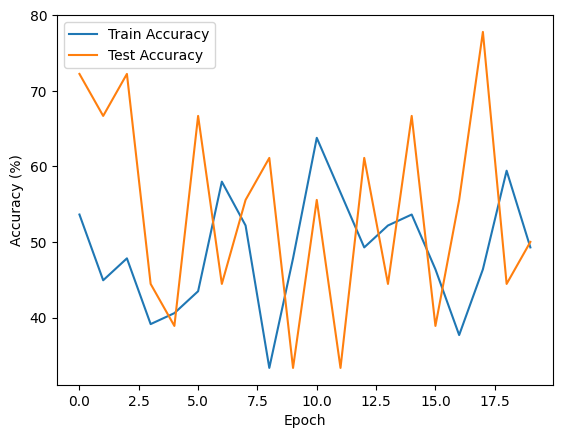

In [63]:
# Plotting Accuracy
plt.figure()
plt.plot(range(epochs), bert_trainer.train_acc_list, label='Train Accuracy')
plt.plot(range(epochs), bert_trainer.test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

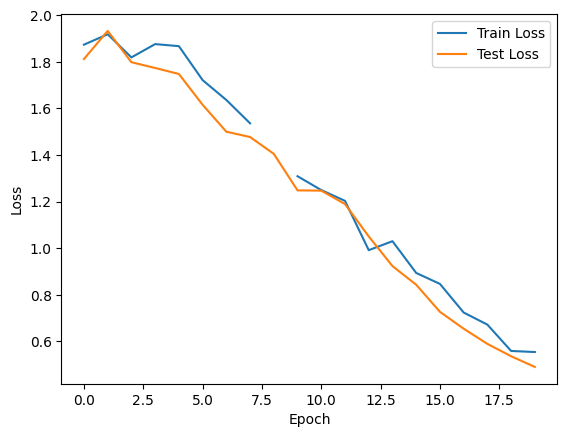

In [64]:
# Plotting Loss
plt.figure()
plt.plot(range(epochs), bert_trainer.train_loss_list, label='Train Loss')
plt.plot(range(epochs), bert_trainer.test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()